In [1]:
import torch
import wandb
from hydra import compose, initialize

from dviforbml.evaluation.visualization.visualize_dvinp import visualize_dvinp
from dviforbml.evaluation.visualization.visualize_task import visualize_task
from dviforbml.utils.helper import download_run_np, get_name_dvinp
from dviforbml.utils.load_dvinp import load_dvinp

In [2]:
# import warnings

# warnings.filterwarnings("ignore")

In [3]:
try:
    import torch_directml

    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

# device = torch.device("cpu")

In [4]:
# project = "cluster-dvinp-new"
# name = "16-8-mean-dis-constr-True-cntxt-1"  # 16-8-mean-dis-free-True-fwdcntxt-0"
# dir = download_run_np(project, name)

dir = "../models/dvinp"

In [5]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    model, trainer, test_loader, val_loader = load_dvinp(
        cfg=cfg,
        device=device,
        dir=dir,
        load_decoder_only=False,
        train_decoder=True,
        debugging=False,
    )


Generating tasks: 100%|██████████| 1024/1024 [00:00<00:00, 312907.42it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


model not found at ../models/dvinp/model.pth
optim not found at ../models/dvinp/optim.pth


In [6]:
# torch.save(model.decoder.state_dict(), f"{dir}/decoder.pth")

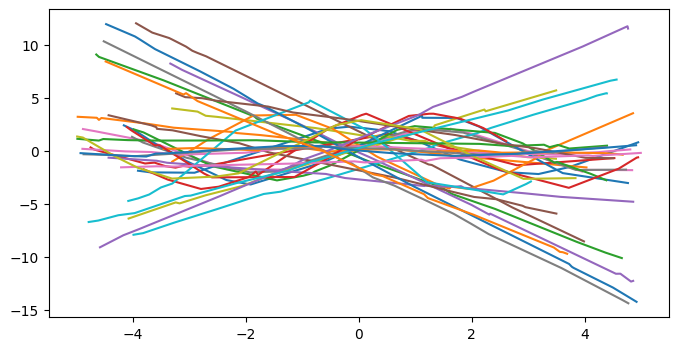

In [7]:
visualize_task(test_loader)

In [8]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="2-tasks", name=get_name_dvinp(cfg))

In [9]:
# model.freeze_decoder()

train = True

if train:
    # trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
    # print(trainer.optimizer.param_groups[0]["lr"])

    num_epochs = 500
    losses = trainer.train(
        num_epochs=num_epochs,
        max_clip_norm=cfg.training.max_clip_norm,
        alpha=None,
        validate=False,
    )

    # torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

  0%|          | 0/8 [00:00<?, ?it/s]/home/chickencurry/dviforbml/.venv/lib/python3.11/site-packages/torch/distributions/normal.py:71: UserWarning: The operator 'aten::normal.Tensor_Tensor' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.normal(self.loc.expand(shape), self.scale.expand(shape))
  0%|          | 0/8 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [10]:
from dviforbml.evaluation.num_eval_np import num_eval_np


num_eval_np(model, val_loader, device, 1024, "test.csv")

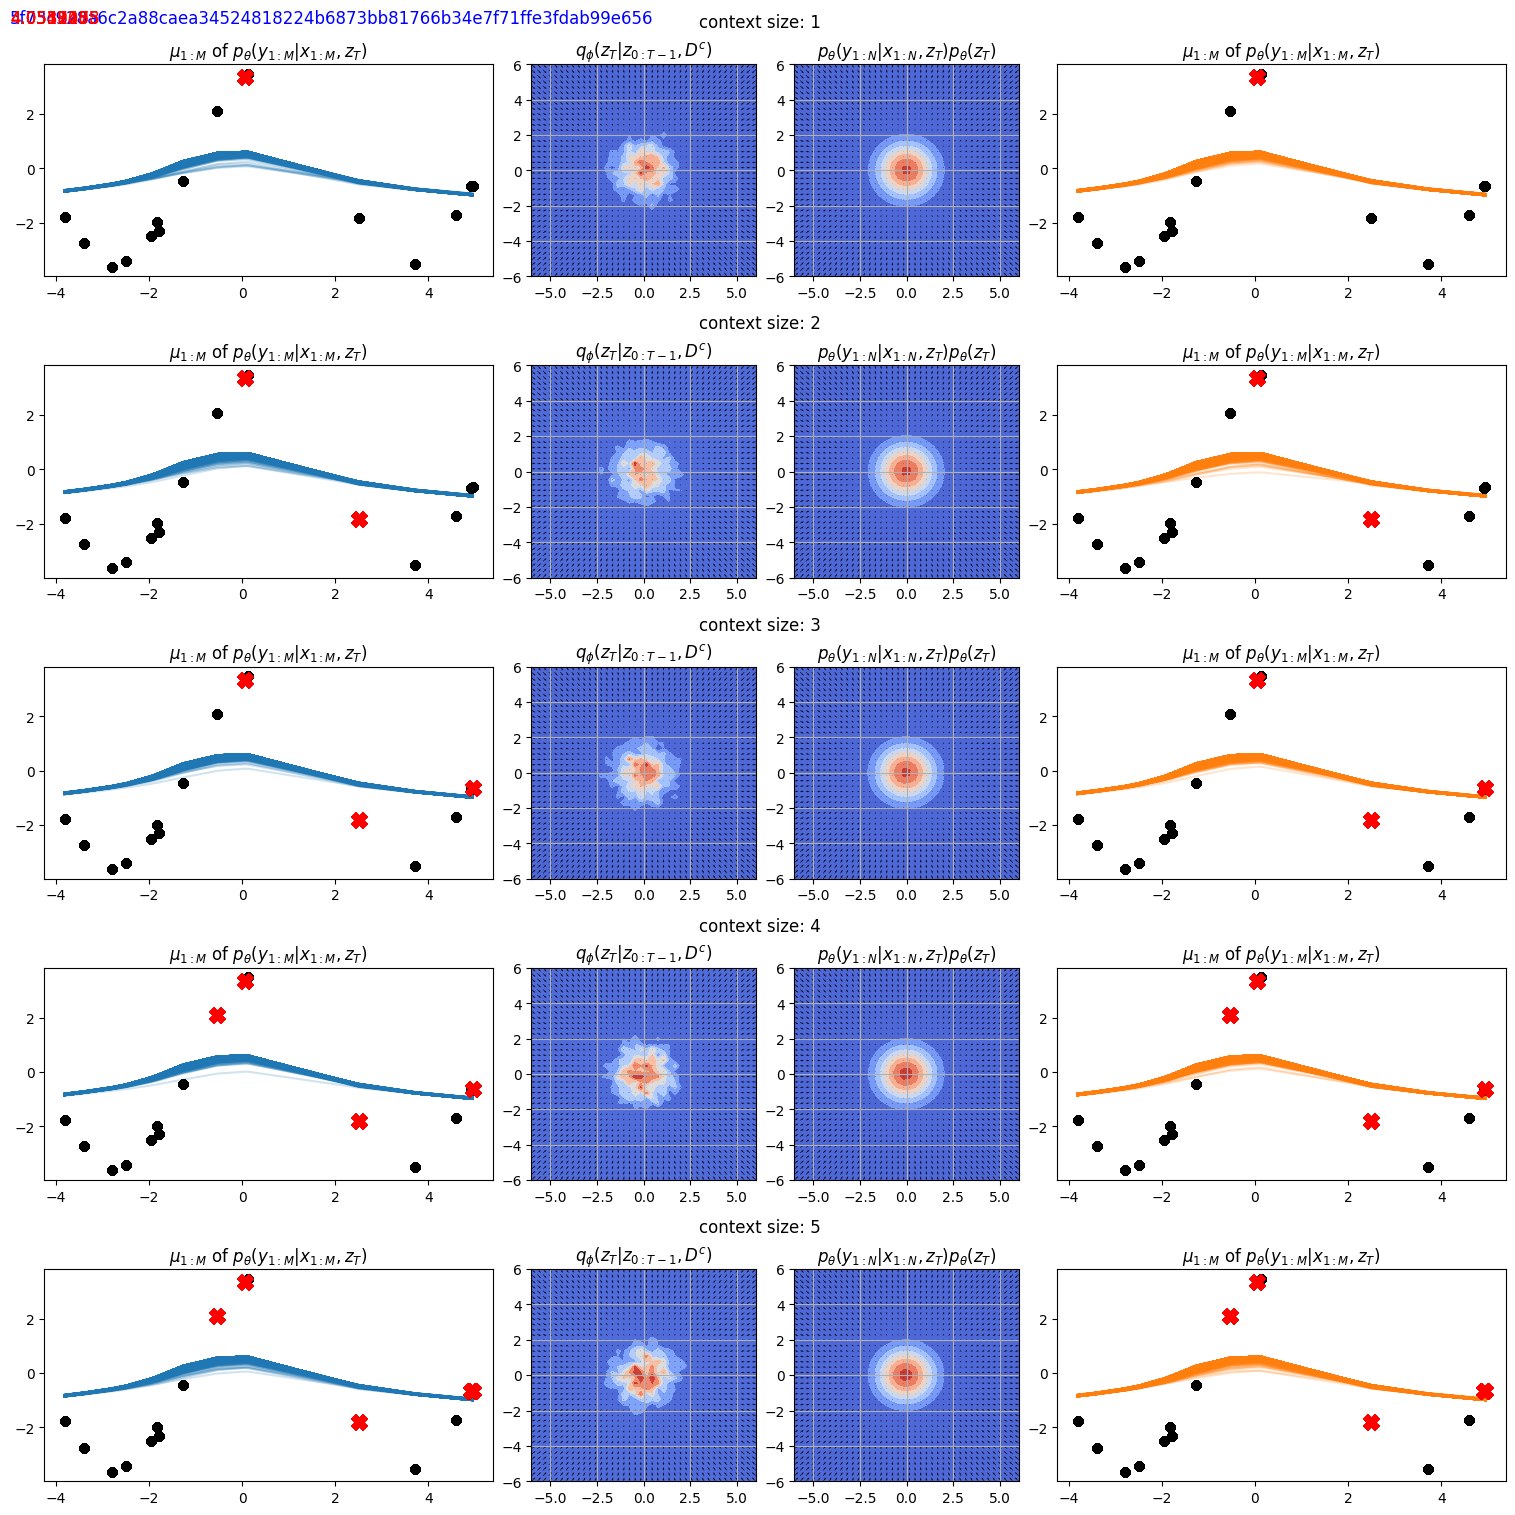

In [11]:
max_context_size = 5
num_samples = 1600  # num_cells will be root

ranges = [(-6, 6), (-6, 6)]

targets, samples = visualize_dvinp(
    device=device,
    dvinp=model,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)

In [ ]:
from dviforbml.components.cdvi.cmcd import CMCD
from dviforbml.components.cdvi.ula import ULA
from dviforbml.components.control.aggr_control import AggrControl
from dviforbml.components.schedule.annealing_schedule import AggrAnnealingSchedule
from dviforbml.components.schedule.free_noise_schedule import AggrFreeNoiseSchedule

annealing_schedule = AggrAnnealingSchedule(
    z_dim=cfg.model.z_dim,
    h_dim=cfg.model.h_dim,
    non_linearity=cfg.model.non_linearity,
    num_steps=cfg.model.num_steps,
    max_context_size=cfg.model.max_context_size,
    device=device,
)

noise_schedule = AggrFreeNoiseSchedule(
    z_dim=cfg.model.z_dim,
    h_dim=cfg.model.h_dim,
    num_steps=cfg.model.num_steps,
    num_layers=cfg.model.num_layers_sched,
    non_linearity=cfg.model.non_linearity,
    max_context_size=cfg.model.max_context_size,
    device=device,
)

control = AggrControl(
    h_dim=cfg.model.h_dim,
    z_dim=cfg.model.z_dim,
    num_steps=cfg.model.num_steps,
    num_layers=cfg.model.num_layers_ctrl,
    non_linearity=cfg.model.non_linearity,
    max_context_size=cfg.model.max_context_size,
    use_score=False,
)

model.cdvi = CMCD(
    z_dim=cfg.model.z_dim,
    num_steps=cfg.model.num_steps,
    control=control,
    step_size_schedule=model.cdvi.step_size_schedule,
    noise_schedule=noise_schedule,
    annealing_schedule=annealing_schedule,
    device=device,
)


model.freeze_decoder()
# model.freeze_encoder()

TypeError: AggrAnnealingSchedule.__init__() missing 1 required positional argument: 'num_layers'